In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-check-deeface/fake/fake_2.jpg
/kaggle/input/data-check-deeface/fake/fake_5.jpg
/kaggle/input/data-check-deeface/fake/fake_3.jpg
/kaggle/input/data-check-deeface/fake/fake_1.jpg
/kaggle/input/data-check-deeface/fake/fake_4.jpg
/kaggle/input/data-check-deeface/real/real_4.jpg
/kaggle/input/data-check-deeface/real/real_3.jpg
/kaggle/input/data-check-deeface/real/real_2.jpg
/kaggle/input/data-check-deeface/real/real_5.jpg
/kaggle/input/data-check-deeface/real/real_1.jpg


In [2]:
!pip install gdown
!pip install tensorboard

In [3]:
!gdown --fuzzy https://drive.google.com/file/d/1fEMM8lkjy6eQcyQ8F4xyjfmoPwCvX2N7/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1fEMM8lkjy6eQcyQ8F4xyjfmoPwCvX2N7
From (redirected): https://drive.google.com/uc?id=1fEMM8lkjy6eQcyQ8F4xyjfmoPwCvX2N7&confirm=t&uuid=7463290d-5b69-4411-b181-da5dfc11e25e
To: /kaggle/working/data.zip
100%|██████████████████████████████████████| 1.86G/1.86G [00:19<00:00, 97.9MB/s]


In [4]:
!unzip -q /kaggle/working/data.zip -d /kaggle/working/data

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import torch.nn.functional as F

2025-06-18 02:02:58.005561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750212178.192803      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750212178.244546      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
transform_no_normalize = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='/kaggle/working/data', transform=transform_no_normalize)

mean = [0.0, 0.0, 0.0]
std = [0.0, 0.0, 0.0]

for image, _ in dataset:
    for i in range(3):
        mean[i] += image[i, :, :].mean()  
        std[i] += image[i, :, :].std()    

mean = [m / len(dataset) for m in mean]
std = [s / len(dataset) for s in std]

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: [tensor(0.4403), tensor(0.4401), tensor(0.4359)]
Std: [tensor(0.2291), tensor(0.2299), tensor(0.2357)]


In [7]:
# Định nghĩa transform (chuẩn hóa và tiền xử lý ảnh)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,  
        std=std
    )
])
# Tải dataset từ thư mục
dataset = datasets.ImageFolder(root='/kaggle/working/data', transform=transform)

# Chia dataset thành tập train và test (tùy chọn)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Kiểm tra số lượng ảnh và nhãn
print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")

Total images: 5182
Classes: ['fake', 'real']


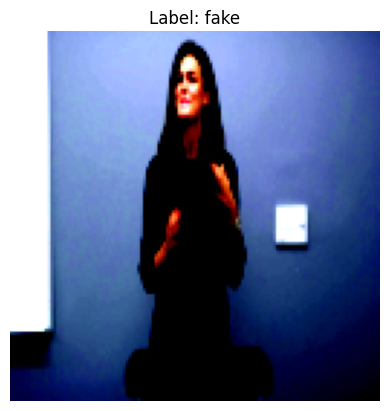

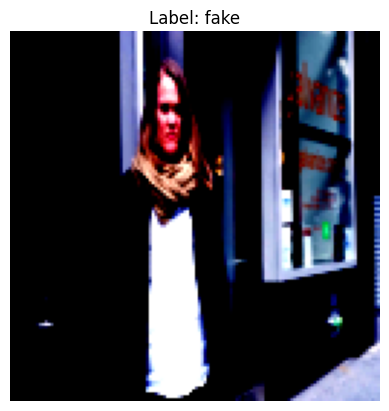

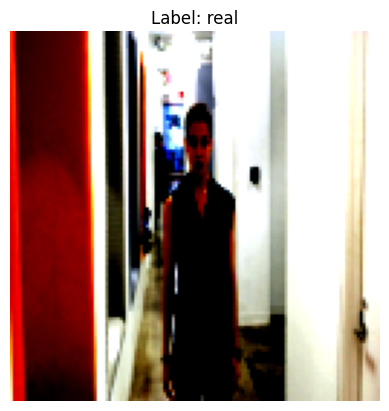

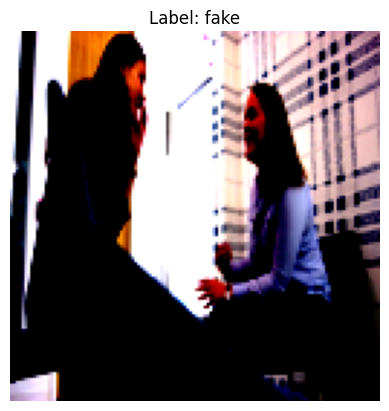

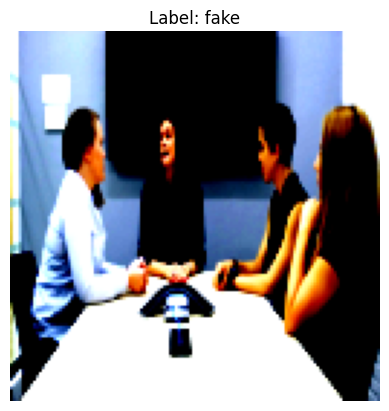

In [9]:
# Lấy ngẫu nhiên 5 ảnh và nhãn từ dataset
for i in range(5):  # In ra 5 ảnh ngẫu nhiên trong dataset
    # Lấy ngẫu nhiên một index từ dataset
    random_index = random.randint(0, len(dataset) - 1)
    image, label = dataset[random_index]

    # Chuyển ảnh về dạng numpy array để hiển thị với matplotlib
    image = image.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) thành (H, W, C)
    
    # Hiển thị ảnh và nhãn
    plt.imshow(image)
    plt.title(f"Label: {dataset.classes[label]}")  # In nhãn (ví dụ: 'real' hoặc 'fake')
    plt.axis('off')  # Tắt trục
    plt.show()

In [10]:
# Thiết lập device (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Xây dựng mô hình CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Lớp Conv1
        self.conv1 = nn.Conv2d(3,128, 3)
        nn.init.normal_(self.conv1.bias, mean=0, std=0.01)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Lớp Conv2
        self.conv2 = nn.Conv2d(128, 256, 3)
        nn.init.normal_(self.conv2.bias, mean=0, std=0.01)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Lớp Conv3
        self.conv3 = nn.Conv2d(256, 512, 3)
        nn.init.normal_(self.conv3.bias, mean=0, std=0.01)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Lớp Conv4
        self.conv4 = nn.Conv2d(512, 1024, 3)
        nn.init.normal_(self.conv4.bias, mean=0, std=0.01)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Fully connected layer
        self.fc = nn.Linear(1024 * 6 * 6, 1)

        # Khởi tạo bias của FC
        nn.init.normal_(self.fc.bias, mean=0, std=0.01)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)

        return x

In [11]:
# Cấu hình TensorBoard
log_dir = "/kaggle/working/runs/_cnn_"
writer = SummaryWriter(log_dir)

In [12]:
model = CNN(1).to(device)

# Hàm mất mát và tối ưu hóa
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Khởi tạo các danh sách để lưu trữ Loss và Accuracy
# Danh sách lưu trữ accuracy
train_losses = []
train_accuracies = []

# Huấn luyện mô hình
for epoch in range(40):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()  # Chế độ huấn luyện

    with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}") as pbar:
        for i, data in pbar:
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Tính accuracy
            predicted = (outputs.squeeze() > 0.5).float()  # Áp dụng threshold 0.5 cho output của CNN
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 5 == 0:
                writer.add_scalar('Loss/train', running_loss / 100, epoch * len(train_loader) + i)
                running_loss = 0.0

            pbar.set_postfix(loss=loss.item())  # Cập nhật thông tin loss lên thanh tiến trình

    # Sau mỗi epoch, tính accuracy
    accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(accuracy)  # Lưu accuracy vào danh sách

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy:.2f}%')

Epoch 1: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, loss=0.573]


Epoch 1, Loss: 0.5730102062225342, Accuracy: 68.10%


Epoch 2: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.295]


Epoch 2, Loss: 0.29456764459609985, Accuracy: 73.61%


Epoch 3: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, loss=0.231]


Epoch 3, Loss: 0.23133300244808197, Accuracy: 75.24%


Epoch 4: 100%|██████████| 114/114 [01:13<00:00,  1.54it/s, loss=0.794]


Epoch 4, Loss: 0.7942067980766296, Accuracy: 76.90%


Epoch 5: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.369]


Epoch 5, Loss: 0.3691469132900238, Accuracy: 77.50%


Epoch 6: 100%|██████████| 114/114 [01:12<00:00,  1.56it/s, loss=0.488]


Epoch 6, Loss: 0.4878135323524475, Accuracy: 78.03%


Epoch 7: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.621]


Epoch 7, Loss: 0.6209365129470825, Accuracy: 78.47%


Epoch 8: 100%|██████████| 114/114 [01:12<00:00,  1.56it/s, loss=0.483]


Epoch 8, Loss: 0.4827883541584015, Accuracy: 79.10%


Epoch 9: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.537]


Epoch 9, Loss: 0.536838173866272, Accuracy: 80.34%


Epoch 10: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.519]


Epoch 10, Loss: 0.5187273621559143, Accuracy: 80.81%


Epoch 11: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.177]


Epoch 11, Loss: 0.1774301677942276, Accuracy: 81.83%


Epoch 12: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.375]


Epoch 12, Loss: 0.37457188963890076, Accuracy: 82.46%


Epoch 13: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.335]


Epoch 13, Loss: 0.33539295196533203, Accuracy: 82.05%


Epoch 14: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.41] 


Epoch 14, Loss: 0.40982192754745483, Accuracy: 82.99%


Epoch 15: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.143]


Epoch 15, Loss: 0.1427314281463623, Accuracy: 82.58%


Epoch 16: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.338]


Epoch 16, Loss: 0.3382948637008667, Accuracy: 83.79%


Epoch 17: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.527]


Epoch 17, Loss: 0.526837944984436, Accuracy: 84.09%


Epoch 18: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.386]


Epoch 18, Loss: 0.3861447274684906, Accuracy: 85.25%


Epoch 19: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.3]  


Epoch 19, Loss: 0.30004751682281494, Accuracy: 84.39%


Epoch 20: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.619]


Epoch 20, Loss: 0.6189425587654114, Accuracy: 85.00%


Epoch 21: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.152]


Epoch 21, Loss: 0.1516377180814743, Accuracy: 86.16%


Epoch 22: 100%|██████████| 114/114 [01:12<00:00,  1.56it/s, loss=0.411]


Epoch 22, Loss: 0.41147077083587646, Accuracy: 86.13%


Epoch 23: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.245]


Epoch 23, Loss: 0.24527013301849365, Accuracy: 87.26%


Epoch 24: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.197]


Epoch 24, Loss: 0.19729836285114288, Accuracy: 87.26%


Epoch 25: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.313]


Epoch 25, Loss: 0.3125486969947815, Accuracy: 86.46%


Epoch 26: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.397]


Epoch 26, Loss: 0.3968767821788788, Accuracy: 87.37%


Epoch 27: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.198]


Epoch 27, Loss: 0.19831955432891846, Accuracy: 87.54%


Epoch 28: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.115]


Epoch 28, Loss: 0.11525518447160721, Accuracy: 88.23%


Epoch 29: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.215]


Epoch 29, Loss: 0.21514356136322021, Accuracy: 88.78%


Epoch 30: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.274]


Epoch 30, Loss: 0.2738725244998932, Accuracy: 88.42%


Epoch 31: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.339]


Epoch 31, Loss: 0.3391532897949219, Accuracy: 89.25%


Epoch 32: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.601]


Epoch 32, Loss: 0.6013084053993225, Accuracy: 89.14%


Epoch 33: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.293]


Epoch 33, Loss: 0.2926865518093109, Accuracy: 88.83%


Epoch 34: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.577] 


Epoch 34, Loss: 0.5774574875831604, Accuracy: 89.16%


Epoch 35: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.923]


Epoch 35, Loss: 0.9232901334762573, Accuracy: 89.47%


Epoch 36: 100%|██████████| 114/114 [01:14<00:00,  1.53it/s, loss=0.181] 


Epoch 36, Loss: 0.1813063621520996, Accuracy: 89.55%


Epoch 37: 100%|██████████| 114/114 [01:13<00:00,  1.55it/s, loss=0.0589]


Epoch 37, Loss: 0.05891687795519829, Accuracy: 90.05%


Epoch 38: 100%|██████████| 114/114 [01:14<00:00,  1.54it/s, loss=0.366]


Epoch 38, Loss: 0.3661443293094635, Accuracy: 90.02%


Epoch 39: 100%|██████████| 114/114 [01:14<00:00,  1.53it/s, loss=0.387]


Epoch 39, Loss: 0.38675421476364136, Accuracy: 89.50%


Epoch 40: 100%|██████████| 114/114 [01:13<00:00,  1.56it/s, loss=0.193] 

Epoch 40, Loss: 0.19262194633483887, Accuracy: 91.23%


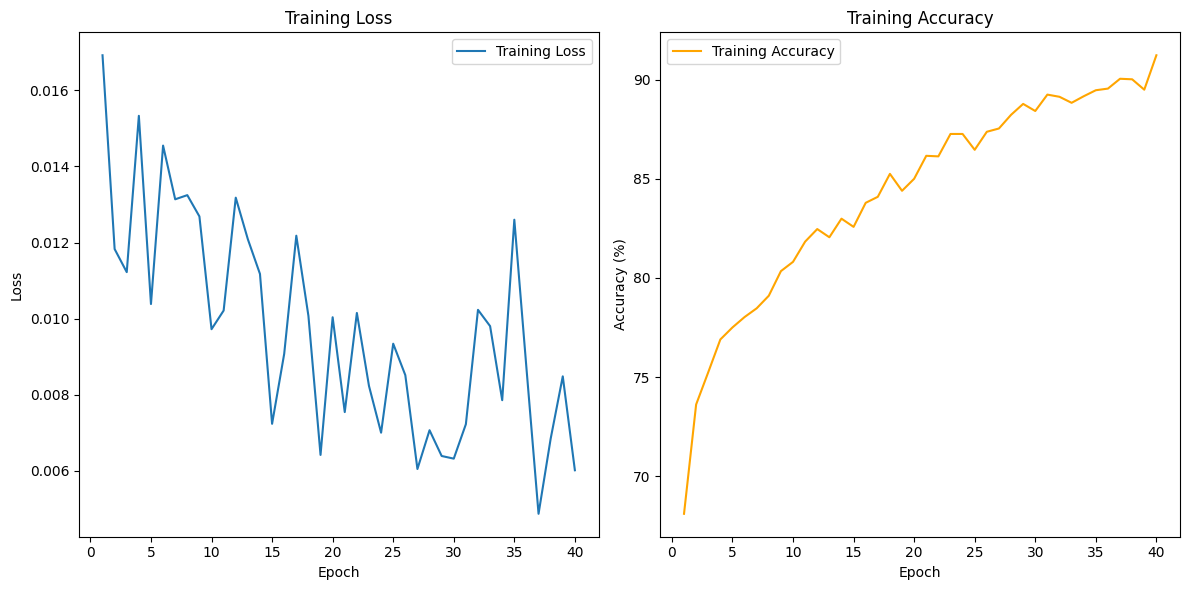

In [13]:
# Vẽ biểu đồ Loss và Accuracy
epochs = range(1, 41)

# Loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Lưu mô hình
torch.save(model.state_dict(), "/kaggle/working/model_cnn.pth")

# Để tải lại mô hình:
model.load_state_dict(torch.load("/kaggle/working/model_cnn.pth"))
model.eval()

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=36864, out_f

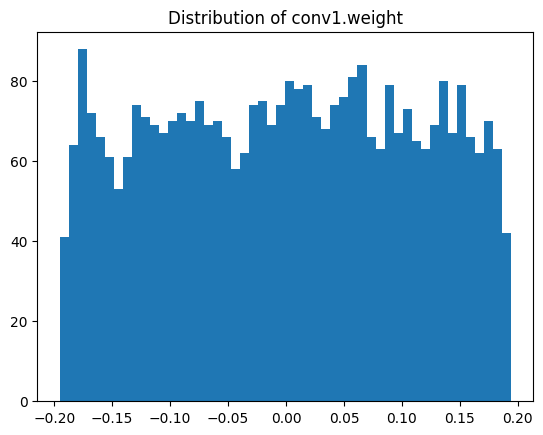

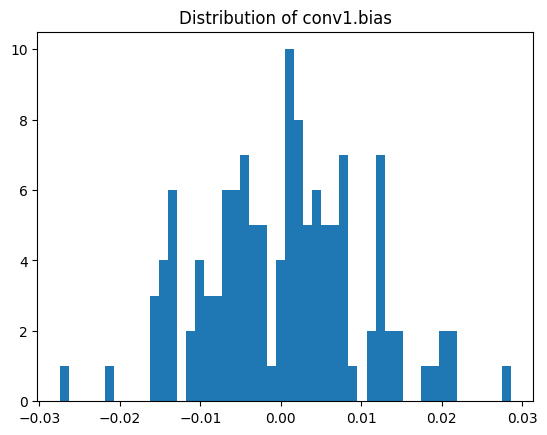

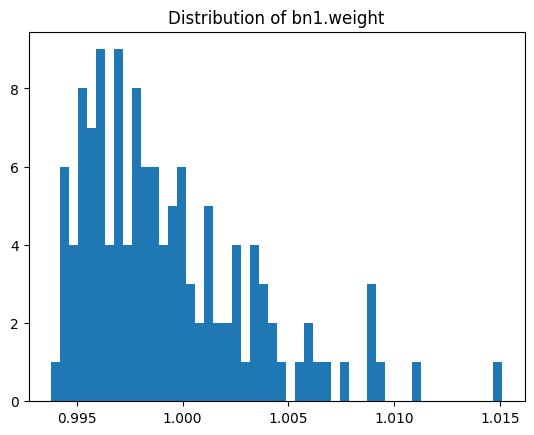

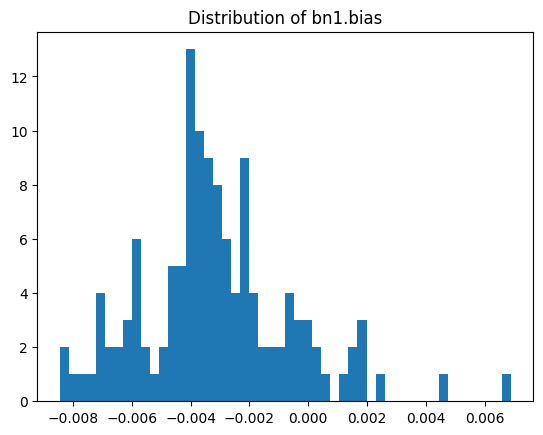

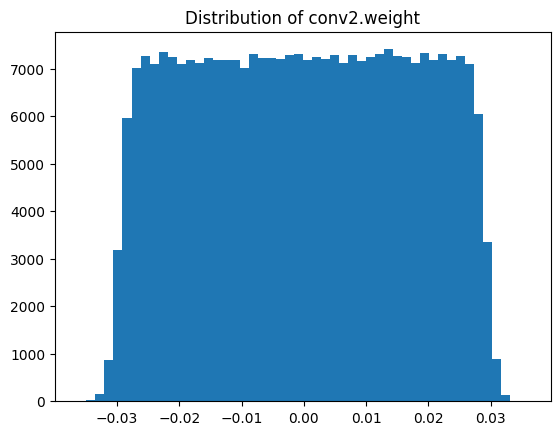

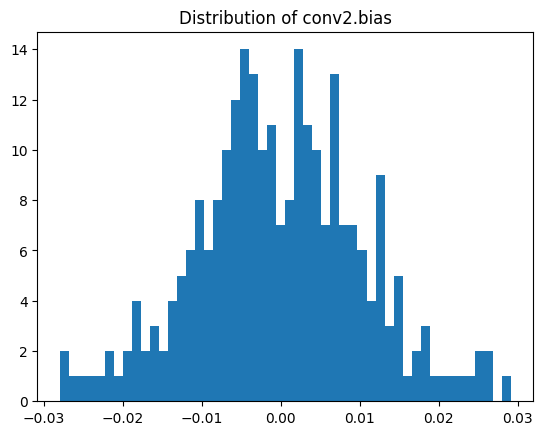

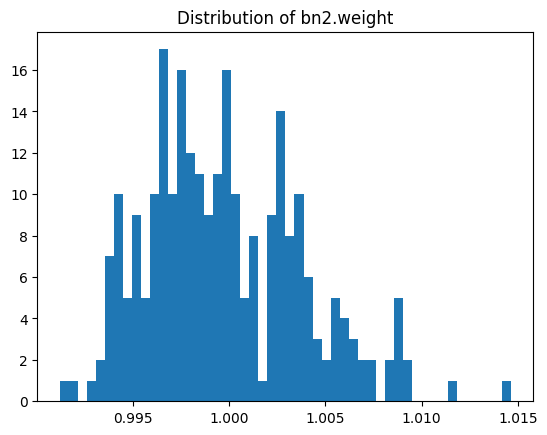

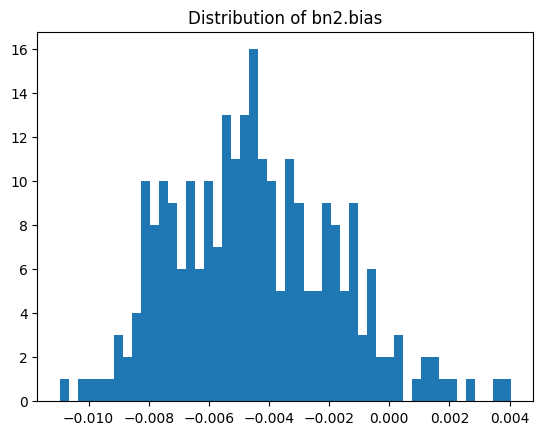

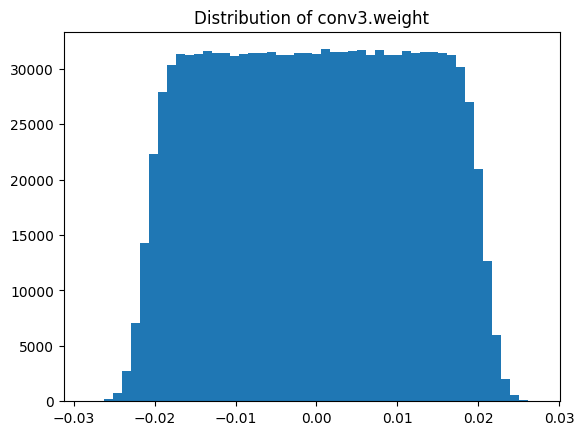

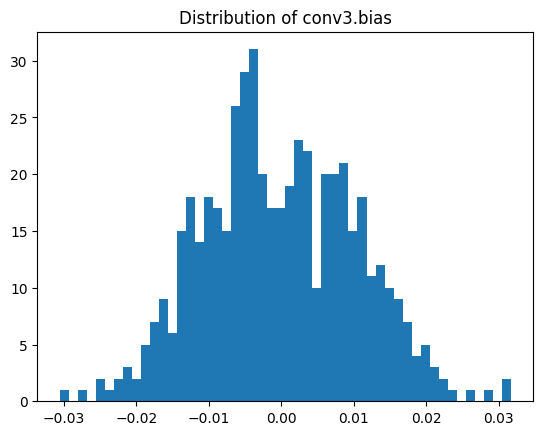

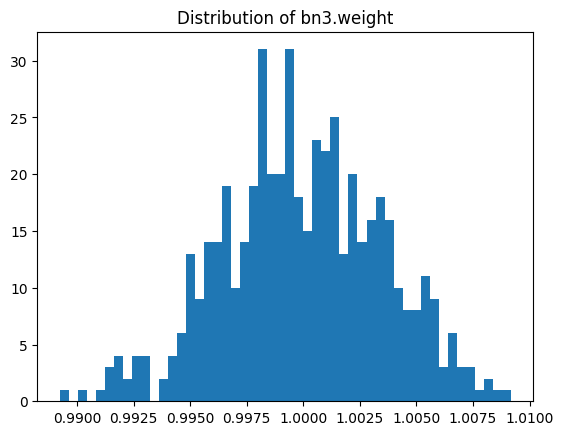

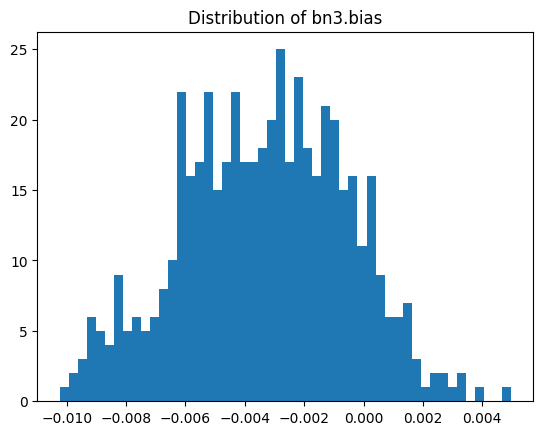

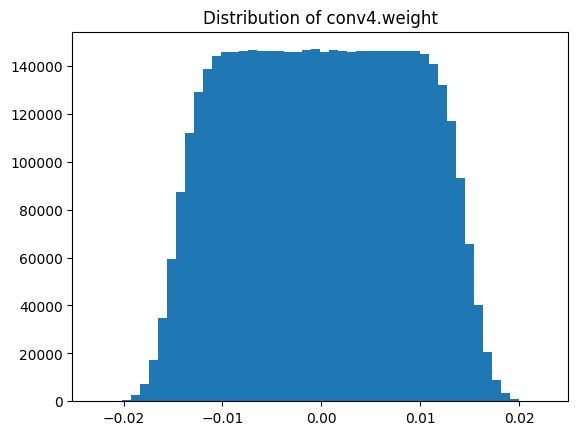

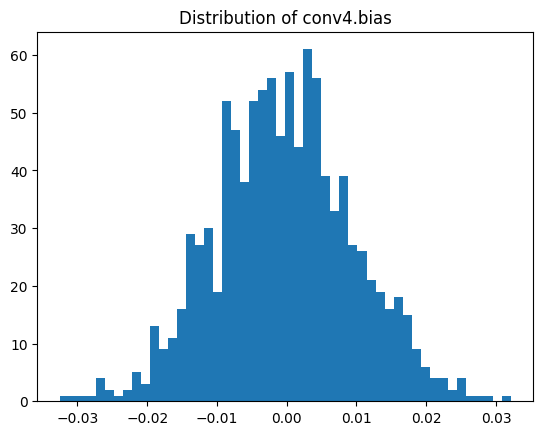

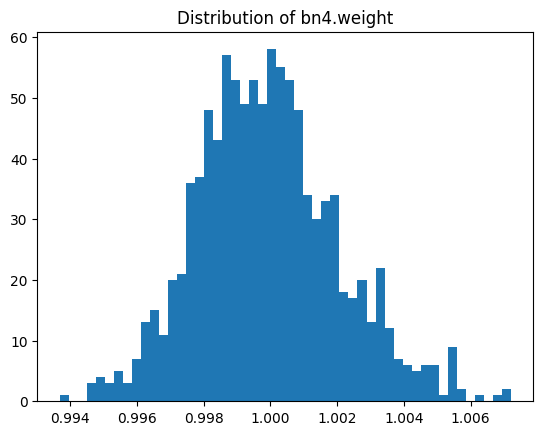

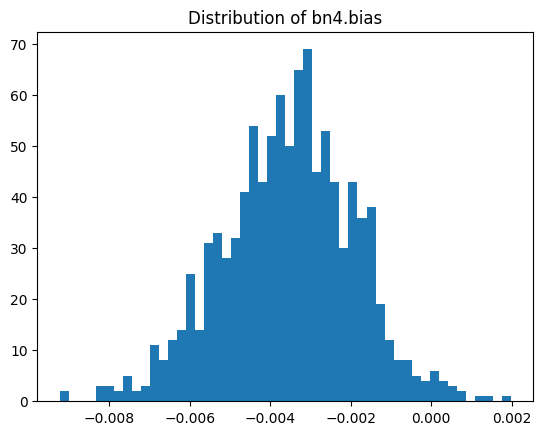

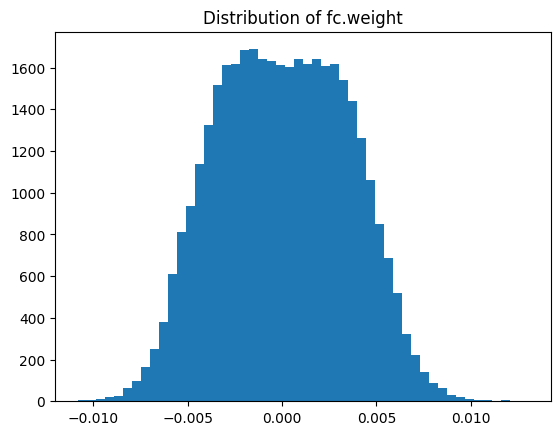

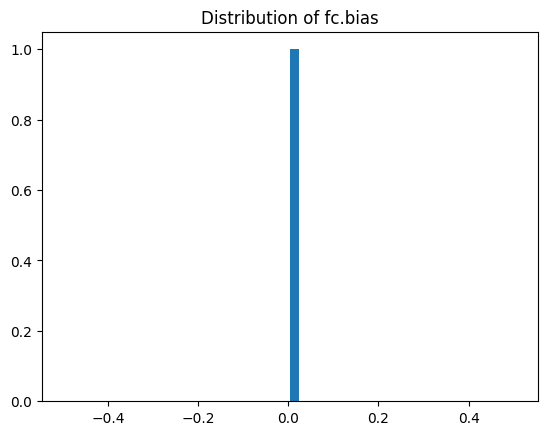

In [15]:
for name, param in model.named_parameters():
    if 'weight' in name:  # Vẽ phân phối của trọng số
        # Chuyển tensor từ GPU sang CPU rồi chuyển thành numpy
        plt.hist(param.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f'Distribution of {name}')
        plt.show()
    if 'bias' in name:  # Vẽ phân phối của bias
        # Chuyển tensor từ GPU sang CPU rồi chuyển thành numpy
        plt.hist(param.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f'Distribution of {name}')
        plt.show()

In [16]:
from PIL import Image

def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img)

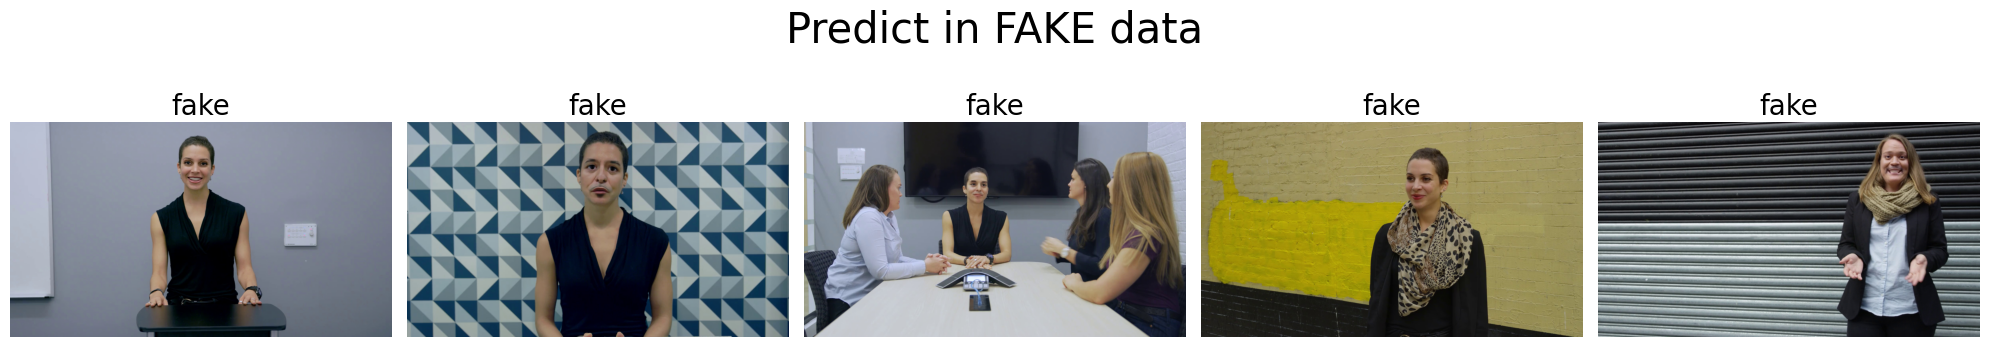

In [17]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Danh sách tên lớp
class_names = ['fake', 'real']

# 2. Duyệt batch ảnh
folder_path = '/kaggle/input/data-check-deeface/fake'
image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.jpg', '.png'))]

# Tạo batch input
input_tensors = [load_and_preprocess_image(p) for p in image_paths]
input_batch = torch.stack(input_tensors)

# Đưa model sang eval mode và device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 4. Dự đoán
with torch.no_grad():
    input_batch = input_batch.to(device)
    probs = model(input_batch)
    predicted_classes = (probs > 0.8918).long().squeeze(1)

# 5. Hiển thị bằng matplotlib
n_images = len(image_paths)
cols = min(5, n_images)
rows = (n_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for idx, (path, pred, prob) in enumerate(zip(image_paths, predicted_classes, probs)):
    img = Image.open(path).convert("RGB")
    label = class_names[pred.item()]
    confidence = prob.item() * 100

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{label}", fontsize=20)

# Ẩn các subplot trống nếu có
for i in range(len(image_paths), len(axes)):
    axes[i].axis('off')

fig.suptitle(f'Predict in {folder_path.split("/")[-1].upper()} data', fontsize=30)
plt.tight_layout()
plt.show()

Số lượng mẫu trong test_loader: 1555


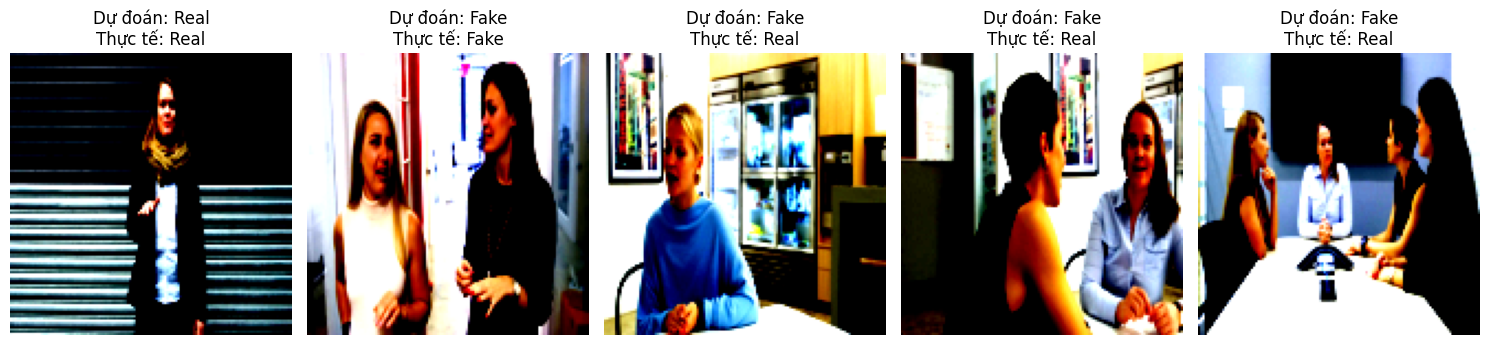

In [23]:
# Kiểm tra số lượng mẫu trong test_loader
print(f"Số lượng mẫu trong test_loader: {len(test_loader.dataset)}")
indices = random.sample(range(len(test_loader.dataset)), 5)

# Danh sách để lưu trữ dự đoán và nhãn thực tế
predictions = []
labels_list = []

# Đảm bảo lấy đúng 5 ảnh
selected_images = []
selected_labels = []

# Duyệt qua các batch trong test_loader và lấy ngẫu nhiên 5 ảnh
for idx in indices:
    image, label = test_loader.dataset[idx]
    selected_images.append(image)
    selected_labels.append(label)

# Cấu hình để vẽ các ảnh trong một hàng
plt.figure(figsize=(15, 5))

# Duyệt qua các ảnh và hiển thị chúng trong một hàng
for i, (inputs, labels) in enumerate(zip(selected_images, selected_labels)):
    inputs = inputs.unsqueeze(0).to(device)

    # Dự đoán kết quả với mô hình
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() >= 0.7).float()

    # Chuyển dữ liệu về CPU và numpy để dễ thao tác
    inputs_np = inputs.cpu().numpy()
    inputs_np = np.transpose(inputs_np, (0, 2, 3, 1)) 

    # Chọn ảnh đầu tiên trong batch
    test_image = inputs_np[0]
    label = labels

    # Dự đoán cho ảnh
    prediction = predicted.item()

    predictions.append(prediction) 
    labels_list.append(label)

    plt.subplot(1, 5, i + 1)  
    plt.imshow(test_image)
    plt.title(f"Dự đoán: {'Real' if prediction == 1 else 'Fake'}\nThực tế: {'Real' if label == 1 else 'Fake'}")
    plt.axis('off')  
    
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, classification_report

true_labels = []
predictions = [] 

for inputs, labels in test_loader:
    inputs = inputs.to(device) 
    
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() >= 0.75).float()  
        
        true_labels.extend(labels.cpu().numpy())  
        predictions.extend(predicted.cpu().numpy())  

# Đánh giá accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy trên tập kiểm tra: {accuracy * 100:.2f}%')  
print(classification_report(true_labels, predictions))

Accuracy trên tập kiểm tra: 73.38%
              precision    recall  f1-score   support

           0       0.67      0.86      0.76       742
           1       0.83      0.62      0.71       813

    accuracy                           0.73      1555
   macro avg       0.75      0.74      0.73      1555
weighted avg       0.75      0.73      0.73      1555



Accuracy trên tập kiểm tra: 74.28%
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       742
           1       0.91      0.56      0.70       813

    accuracy                           0.74      1555
   macro avg       0.79      0.75      0.74      1555
weighted avg       0.79      0.74      0.73      1555



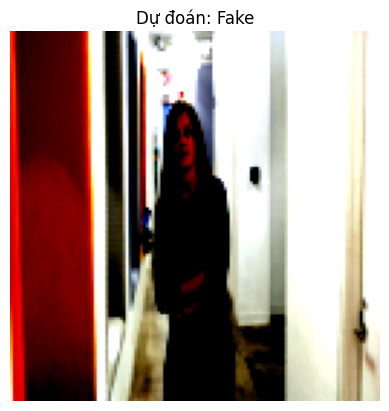

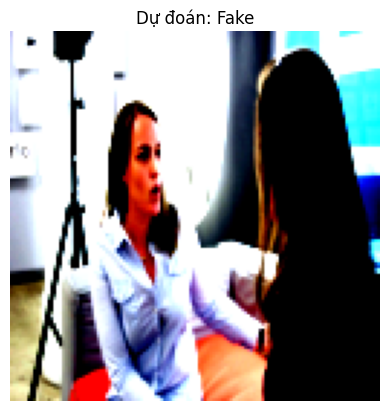

In [ ]:
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs) 
        predicted_labels = (outputs.squeeze() >= 0.9).float()

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())

# Tính toán accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy trên tập kiểm tra: {accuracy * 100:.2f}%')

print(classification_report(true_labels, predictions))

for i in range(min(5, len(inputs))):  
    img = inputs[i].cpu().numpy().transpose(1, 2, 0)  
    plt.imshow(img)
    plt.title(f"Dự đoán: {'Real' if predictions[i] == 1 else 'Fake'}")
    plt.axis('off')
    plt.show()


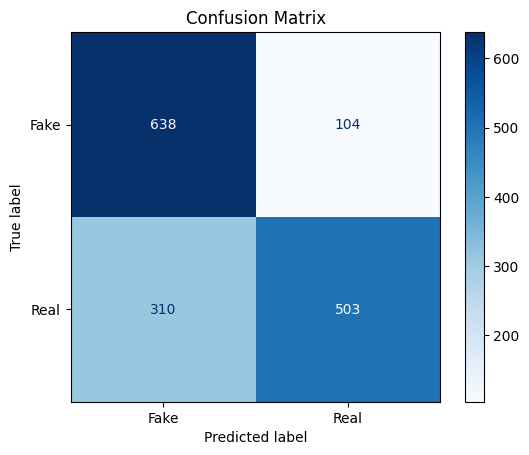

Confusion Matrix:
[[638 104]
 [310 503]]


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Giả sử bạn đã có danh sách dự đoán và nhãn thực tế
# predictions: là kết quả dự đoán của mô hình (dự đoán là 0 hoặc 1)
# labels_list: là nhãn thực tế (0 hoặc 1)

# Dự đoán với mô hình và thu thập các dự đoán và nhãn thực tế
predictions = []
labels_list = []

# Lặp qua các batch trong test_loader và lấy các dự đoán
for inputs, labels in test_loader:
    inputs = inputs.to(device)  # Đưa ảnh vào device (CPU/GPU)

    # Dự đoán kết quả với mô hình
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() >= 0.75).float()  # Sử dụng ngưỡng 0.5

    # Lưu trữ nhãn thực tế và dự đoán
    predictions.extend(predicted.cpu().numpy())
    labels_list.extend(labels.cpu().numpy())

# Tính toán confusion matrix
cm = confusion_matrix(labels_list, predictions)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)  # Vẽ confusion matrix với màu sắc đẹp
plt.title("Confusion Matrix")
plt.show()

# In kết quả confusion matrix
print("Confusion Matrix:")
print(cm)
